# Проект №4: Компьютер говорит "Нет"

Целью проекта является написание скоринговой модели предсказания дефолта клиентов банка

Импортируем необходимые библиотеки

In [3330]:

import numpy as np 
import pandas as pd 



from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score



from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer




from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import datetime 
from datetime import datetime, timedelta


Сохраним состояние генератора псевдослучайных чисел

In [3331]:
RANDOM_SEED = 42

Загрузим тренировочный и тестовый датасеты 

In [3332]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

Сгенерируем столбец 'Train', значения которых помогут нам различать тренировочную и тестовую выборки

In [3333]:
data_train['Train'] = 1
data_test['Train'] = 0 


Объеденим тестовую и тренировочную выборки

In [3334]:
data = data_train.append(data_test, sort=False).reset_index(drop=True) 
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1


основная информация о данных:

In [3335]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
default             73799 non-null float64
Train               110148 non-null int64
dtypes: float64(2), int64(12), object(6)

Объеденённый датасет содержит 110148 строк и 20 столбцов, из которых 14 имеют числовой тип, 6 - категориальный

При более детальном рассмотрении стало понятно, что датасет состоит из набора бинпрных, категориальных, числовых и одного временного столбца. Соеденим названия столбцов в соответствующие группы

In [3336]:
bin_cols=['sex','car', 'car_type', 'foreign_passport', 'good_work'] #бинарные
cat_cols=['education', 'home_address', 'work_address'] # категориальные
num_cols=['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'timedelta'] # числовые
time_cols = ['app_date'] # временнЫе

Проверим датасет на наличие пропусков:

In [3337]:
data.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

Мы видим, что пропуски есть только в столбце data['education']. Позже вернёмся к заполнению этих пропусков.

# Анализ данных в столбцах

В столбце data['app_date'] содержатся текстовые данные о дате. Преобразуем их в тип datetime и посчитаем временной интервал между каждым событием и константной датой. Временные интервалы преобразуем в числовой вид

In [3338]:
#функция преобразует значения из текстового в формат datetime
def datefunc(row):
    da=datetime.strptime(row['app_date'], '%d%b%Y')
    return da

In [3339]:
#применим вышесозданную функцию к столбцу с данными о дате
data['app_date']=data.apply(datefunc, axis=1)

Зададим константную дату от которой будем отсчитывать промежутки времени для всех остальных дат

In [3340]:
const_date=data['app_date'].max()

In [3341]:
data['timedelta']=const_date-data['app_date']  #посчитаем временные промежутки и сохраним результат в отдельный столбец
data['timedelta']=data.apply(lambda x: x['timedelta'].total_seconds()/10000,axis=1) #приобразуем значения в числовой формат, переведя значения в секунды и поделив  его на 10000

Убедимся, что в результате преобразования у нас появился столбец с числовыми данными о временных промежутках

In [3342]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,50,1,2,18000,4,1,N,0.0,1,760.32
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,50,2,3,19000,4,1,N,0.0,1,423.36
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,80,1,2,30000,1,4,Y,0.0,1,760.32


# Заполним пропуски

Как мы убедились выше столбец data['education'] содержит многочисленные пропуски.
Давайте внимательнее изучим какие ещё значения он содержит

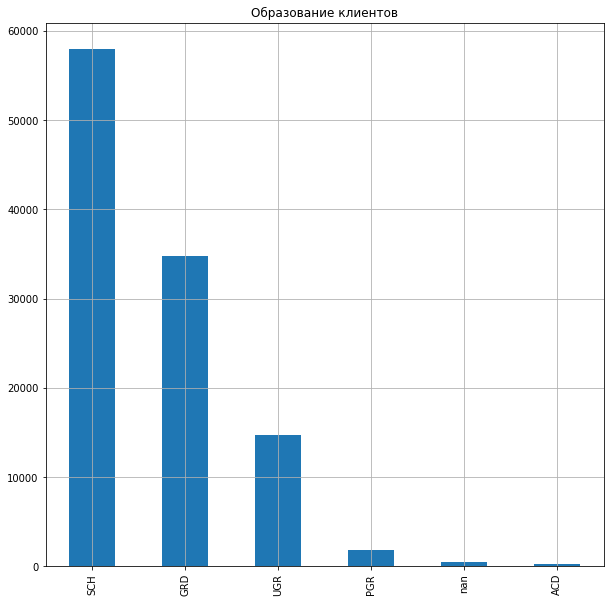

In [3343]:
data['education'].astype('str').value_counts().plot(kind='bar', grid=True, title= 'Образование клиентов')

Мы видим, что самым популярным значением в этом столбце является школьное образование. Но, поскольку людей с высшим образованием тоже много, предположем, что люди с более высоким уровнем дохода имеют высшее образование.
Создадим фунцию, которая в пропусках людям с уровнем дохода высшим чем третий квантиль присваивает высшее образование, остальным школьное. Скорее всего это не повлияет на работу модэли, но является отличным поводом потренироваться решать подобные задачи.


In [3344]:
from functools import partial # библиотека для более высокоупорядоченных функций

def fill_edu(quan75, row):   # функция принимает 2 переменные
    edu=row['education']
    if type(edu) is not str:   # метод "isna" не срабатывал, поэтому просто выполняем для всех нестроковых значений
        if row['income'] > quan75:  # если значение дохода больше переменной quan75, значеник которой мы определим при выполнении функции
            return 'GRD' #назначаем высшее образование
        else:
            return 'SCH'# в остальных случаях школу
        
    else:
        return edu
    


functools.partial(func[,*args][, **keywords]) принимает на вход функцию и значение для неё

In [3345]:
data['education']=data.apply(partial(fill_edu, data['income'].quantile(0.75)), axis=1)

Проверим не осталось ли пропусков

In [3346]:
data['education'].isnull().sum()

0

Создадим функцию для определения основных статистических показателей

In [3347]:
def range_outliers(x):
    xmedian=x.median()
    xperc25=x.quantile(0.25)
    xperc75=x.quantile(0.75)
    xIQR=xperc75-xperc25
    print('медиана:{},'.format(xmedian),'25% персентиль:{},'.format(xperc25), '75% персентиль:{},'.format(xperc75), 'IQR:{},'.format(xIQR), 'границы выбросов: [{f},{l}]'.format(f=xperc25-1.5*xIQR, l=xperc75+1.5*xIQR))

Посмотрим на распределение числовых признаков:

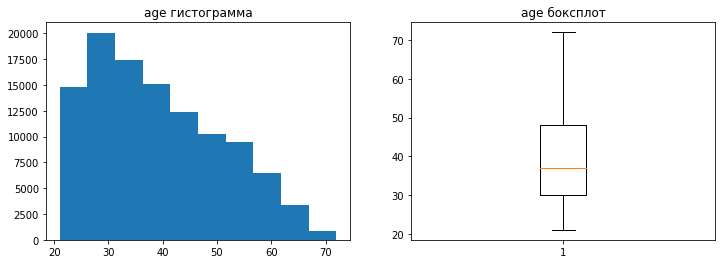

медиана:37.0, 25% персентиль:30.0, 75% персентиль:48.0, IQR:18.0, границы выбросов: [3.0,75.0]


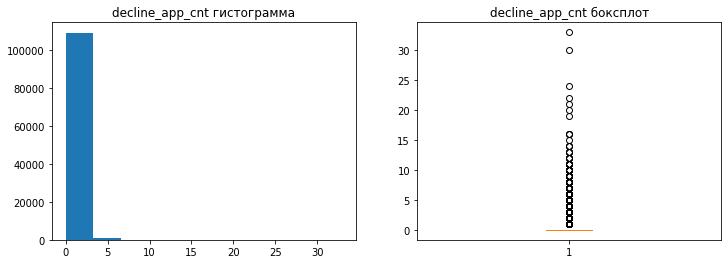

медиана:0.0, 25% персентиль:0.0, 75% персентиль:0.0, IQR:0.0, границы выбросов: [0.0,0.0]


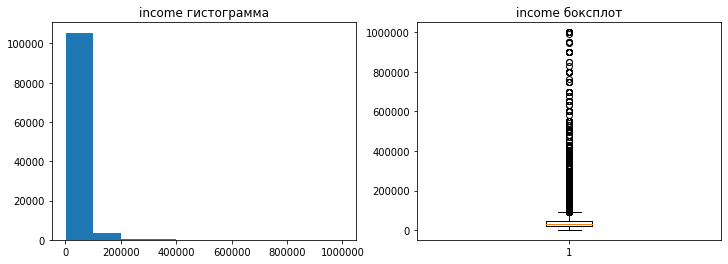

медиана:30000.0, 25% персентиль:20000.0, 75% персентиль:48000.0, IQR:28000.0, границы выбросов: [-22000.0,90000.0]


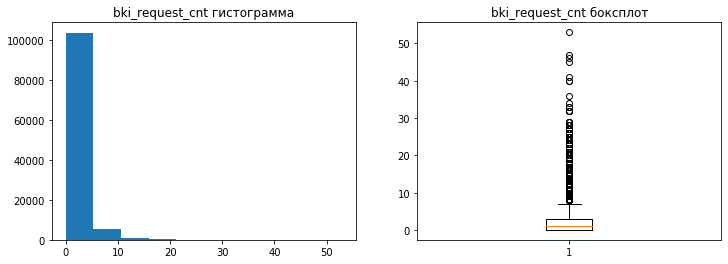

медиана:1.0, 25% персентиль:0.0, 75% персентиль:3.0, IQR:3.0, границы выбросов: [-4.5,7.5]


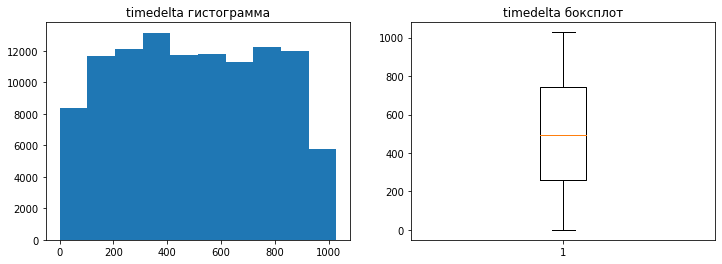

медиана:492.48, 25% персентиль:259.2, 75% персентиль:743.04, IQR:483.84, границы выбросов: [-466.56,1468.8]


In [3348]:
for i in num_cols:
    
    fig,axes=plt.subplots(1,2, figsize=(12,4))
    
    axes[0].hist(data[i])
    axes[0].set_title(i+ ' гистограмма')
    axes[1].boxplot(data[i])
    axes[1].set_title(i+ ' боксплот')
    plt.show()
    range_outliers(data[i])

После построения гистограмм стало очевидно, что распределения всех числовых переменных, кроме 'timedelta' имеют тяжёлый правый хвост. Для ролучения более равномерного распределения логарифмируем признаки. И посмотрим как изменятся графики 

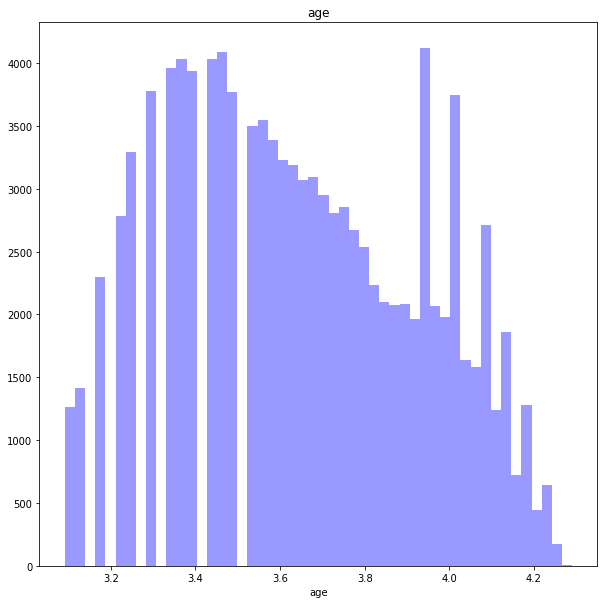

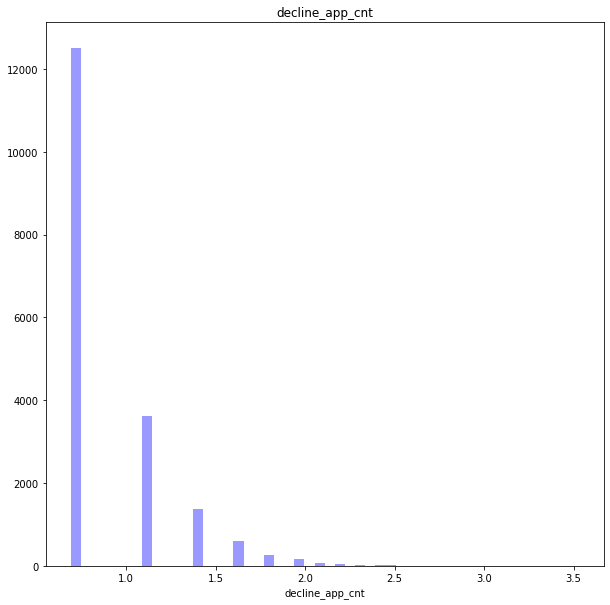

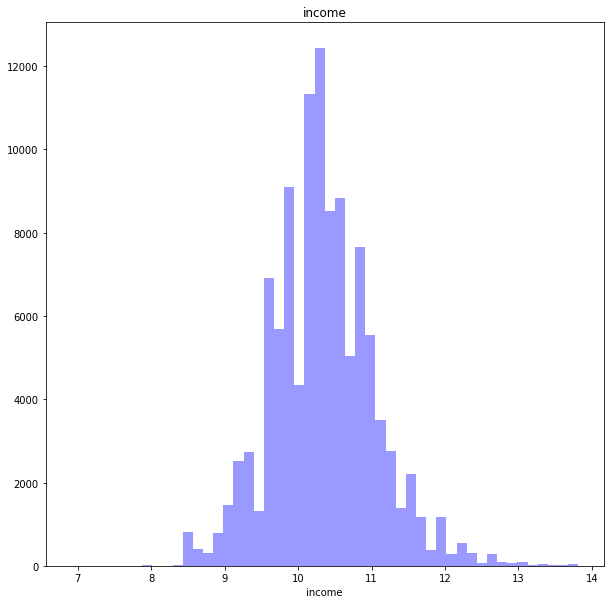

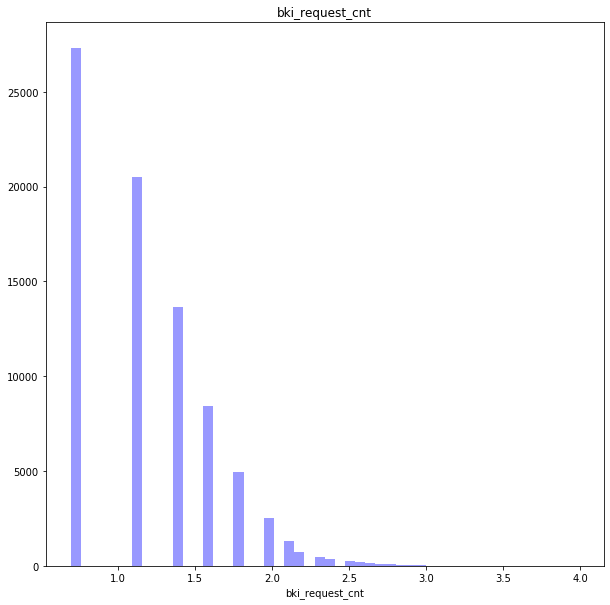

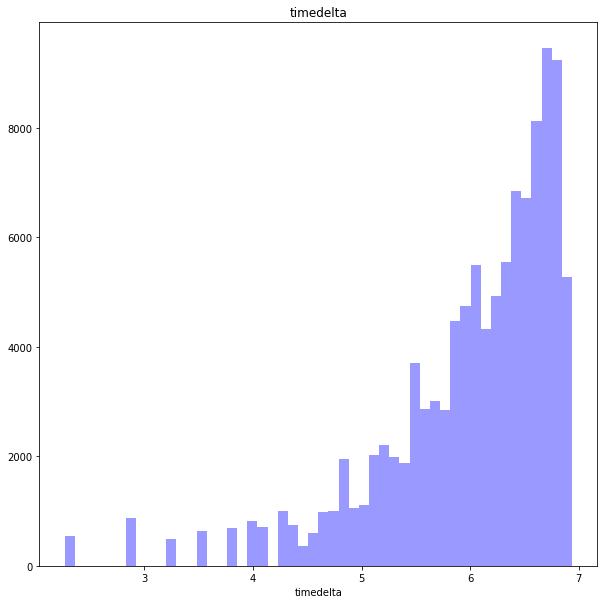

In [3349]:
for i in num_cols:
    data[i] = np.log(data[i] + 1)
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

Посмотрим как теперь выглядят столбцы м числовыми значениями

In [3350]:
data[num_cols].head(3)

,age,decline_app_cnt,income,bki_request_cnt,timedelta
0,4.143135,0.000000,9.798183,0.693147,6.635054
1,4.094345,0.000000,9.852247,1.386294,6.050582
2,3.258097,1.098612,10.308986,0.693147,6.635054


# Корреляция числовых признаков

In [3351]:
correlation=data[num_cols].corr()
correlation

,age,decline_app_cnt,income,bki_request_cnt,timedelta
age,1.000000,-0.128624,-0.090734,0.050241,-0.016174
decline_app_cnt,-0.128624,1.000000,-0.013959,0.127531,0.020797
income,-0.090734,-0.013959,1.000000,0.078649,-0.004006
bki_request_cnt,0.050241,0.127531,0.078649,1.000000,0.001212
timedelta,-0.016174,0.020797,-0.004006,0.001212,1.000000


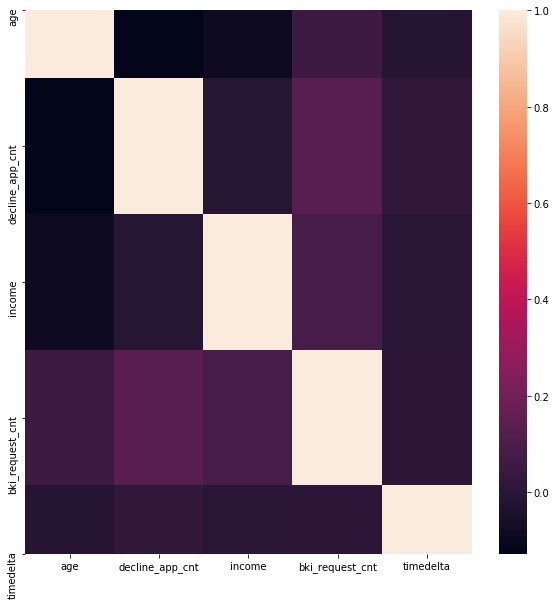

In [3352]:
sns.heatmap(correlation)

Мы видим лишь слабую между 'decline_app_cnt' и 'bki_request_cnt'. Для дальнейшей оценки проверим значимость этих признаков.

# Оценка значимости числовых признаков

Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

In [3353]:

f_classif(data[num_cols][data['Train']==1], data['default'][data['Train']==1])

(array([  50.3805738 , 1152.93731744,  214.7905274 ,  457.59176046,
         105.25892221]),
 array([1.27778005e-012, 8.96214000e-251, 1.44923016e-048, 3.26668128e-101,
        1.11349182e-024]))

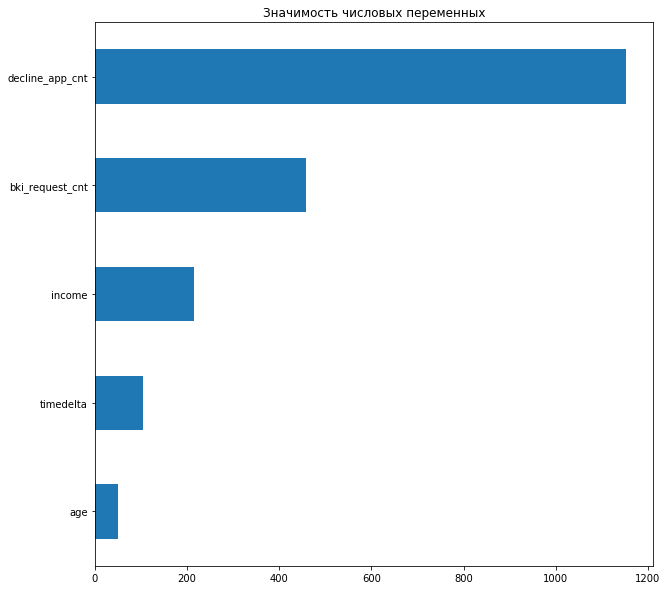

In [3354]:
imp_num = pd.Series(f_classif(data[num_cols][data['Train']==1], data['default'][data['Train']==1])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых переменных')

Согласно методу  f_classif, decline_app_cnt - самый значимый признак, в то время, как возраст клиента  имеет наименьшую значимость

# Бинарные признаки

Преобразуем значения бинарных признаков в нули и единицы

In [3355]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    data[column] = label_encoder.fit_transform(data[column])


In [3356]:
data.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.0,0,-2.008753,...,50,1,2,9.798183,4,1,0,0.0,1,6.635054
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.0,0,-1.532276,...,50,2,3,9.852247,4,1,0,0.0,1,6.050582


Посмотрим на сколько сбалансированы бибинарные признаки

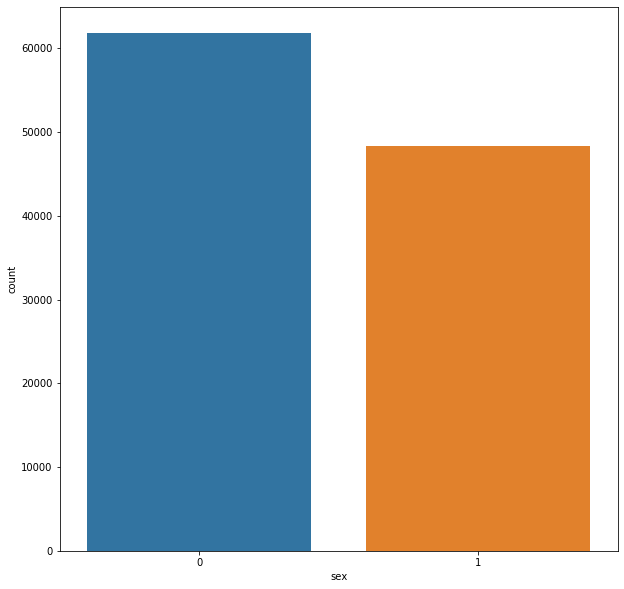

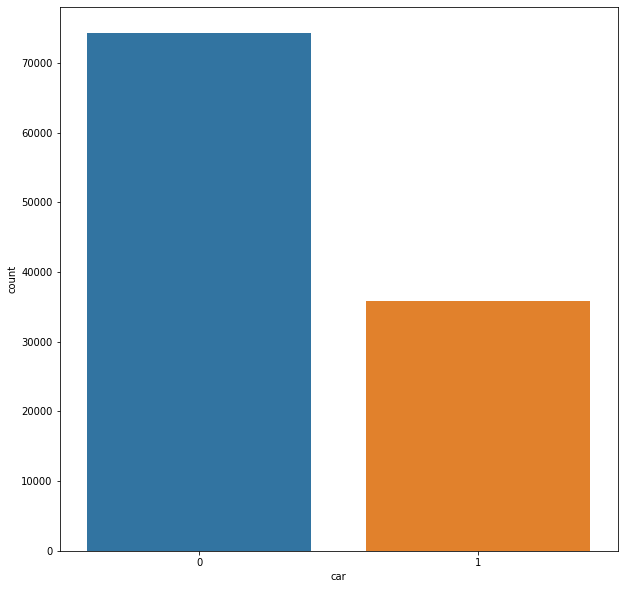

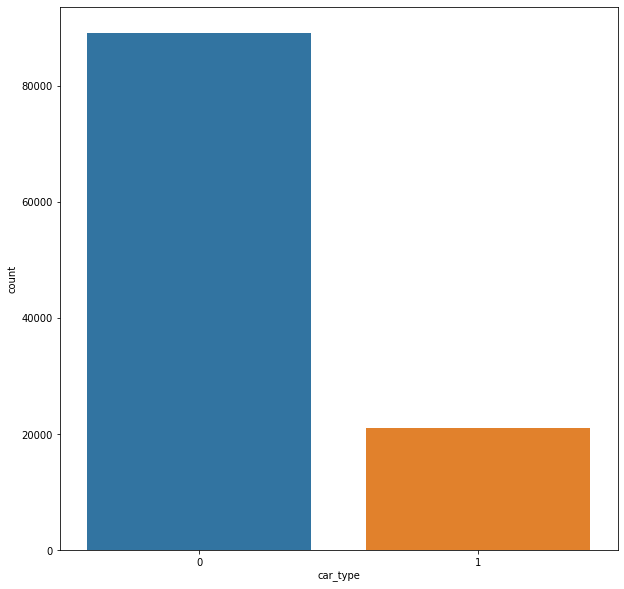

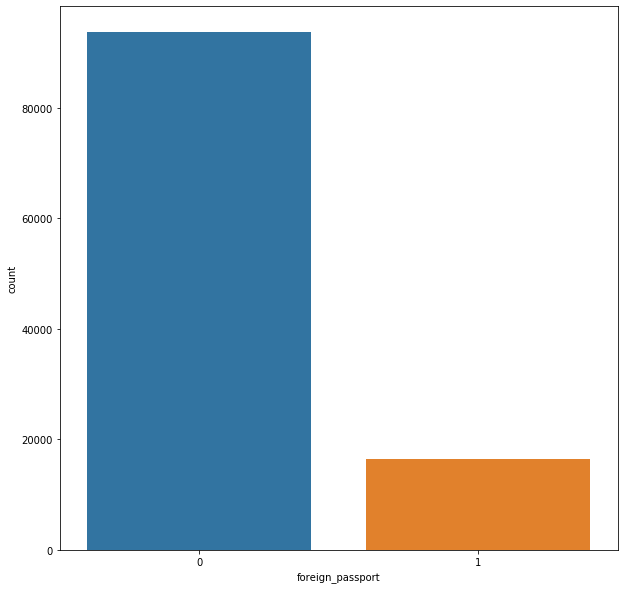

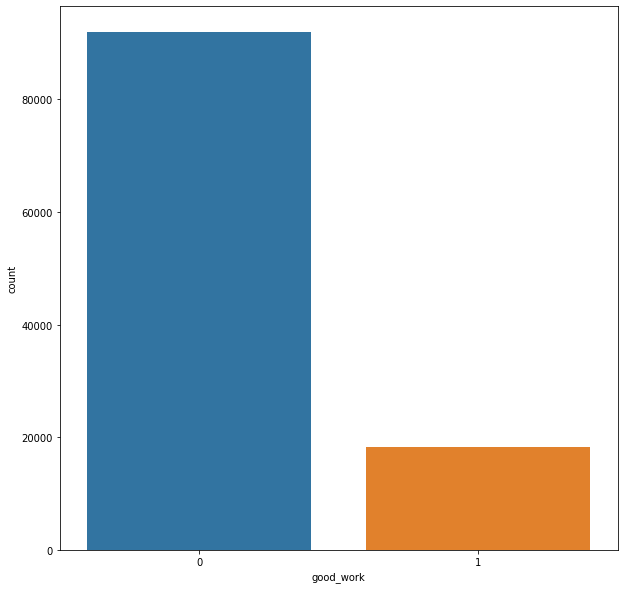

In [3357]:
for column in data[bin_cols]:
    bin_cal_val=data[column].value_counts()
    #bin_cal_val.plot(kind='bar', title=column)
    sns.countplot(x=data[column], data=data[bin_cols])
    plt.show()
    #sns.barplot(x=bin_cal_val, data=bin_cal_val)


Мы видиим, что фича о дорогой машине и хорошей работе менее всего сбалансированы.

# Категориальные признаки

Применим к столбцу образования LabelEncoder, чтоб преобразовать его значения в числовые

In [3358]:
le =preprocessing.LabelEncoder()
le.fit(list(data['education'].values) )
data['education']=le.transform(list(data['education'].values))
data['education_label']=data['education']


In [3359]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0.0,1,6.635054,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0.0,1,6.050582,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0.0,1,6.635054,3


Получим расшифровку того как метод LabelEncoder переназначил категориальные значения столбца education

In [3360]:
print(dict(enumerate(le.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


Перед тем как преобразовать категориальный признаки в векторы OneHotEncoder, оценим их значимость.

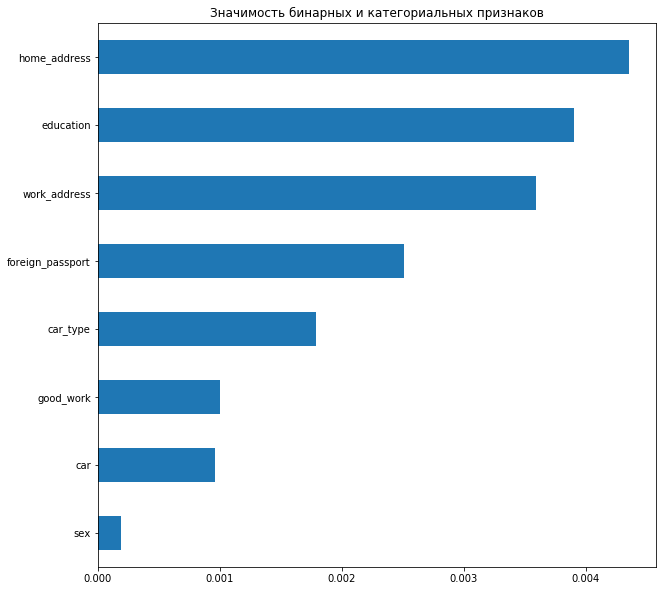

In [3361]:
mutal=pd.Series(mutual_info_classif(data[cat_cols+bin_cols][data['Train']==1], data['default'][data['Train']==1], discrete_features =True), index=cat_cols+bin_cols).sort_values()
mutal.plot(kind = 'barh', title = 'Значимость бинарных и категориальных признаков')

Мы видим, что наибольшее влияние на модель оказывают адресс и образование, в то время, как пол влияет минимально.

Применим OneHotEncoder к категориальным признакам

In [3362]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols][data['Train']==1].values)
#подготовим также тестовый данные для тестового массива
X_cat_test = OneHotEncoder(sparse = False).fit_transform(data[cat_cols][data['Train']==0].values)



Стандартизируем числовые переменные

In [3363]:
X_num =StandardScaler().fit_transform(data[num_cols][data['Train']==1].values)
#подготовим также тестовый данные для тестового массива
X_num_test =StandardScaler().fit_transform(data[num_cols][data['Train']==0].values)


Теперь числовые признаки имеют одинаковый масштаб, что даёт возможность применения метода градиентного спуска

Соеденим подготовленные данные в массивы

In [3364]:
X=np.hstack([X_num, data[bin_cols][data['Train']==1].values, X_cat])
y=data['default'][data['Train']==1].values

In [3365]:
#подготовим также тестовый массив
X_Test=np.hstack([X_num_test, data[bin_cols][data['Train']==0].values, X_cat_test])

Поделим выборку на тренировочную и тестовую 

In [3366]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Применим модель

In [3367]:
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Предскажем значения целевой переменной для оценки работы модели

In [3368]:
y_pred_1=model_1.predict(X_test)

Определим метрики

In [3369]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_1)))
print('Precision:'+str(precision_score(y_test, y_pred_1)))
print('Recall:'+str(recall_score(y_test, y_pred_1)))
print('f1: ' + str(f1_score(y_test, y_pred_1)))

Accuracy:0.876219512195122
Precision:0.5
Recall:0.003284072249589491
f1: 0.006525285481239804


Определим кривую ROC AUC  

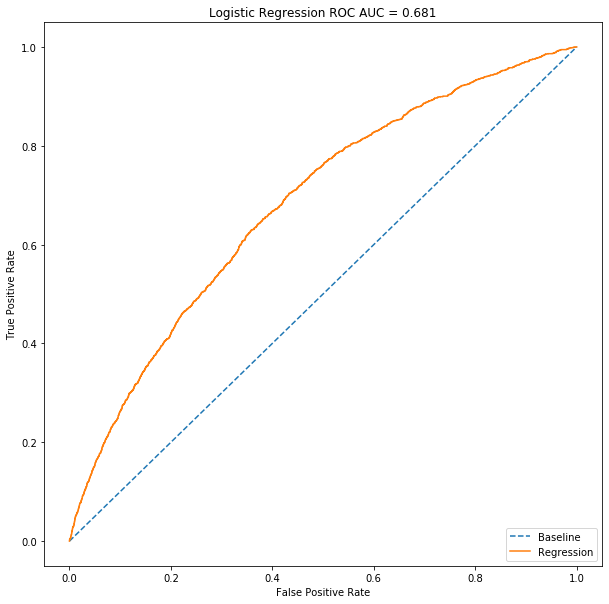

In [3370]:

probs_1 = model_1.predict_proba(X_test)
probs_1 = probs_1[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_1)
roc_auc = roc_auc_score(y_test, probs_1)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Матрица ошибок:

array([[12927,     6],
       [ 1821,     6]], dtype=int64)

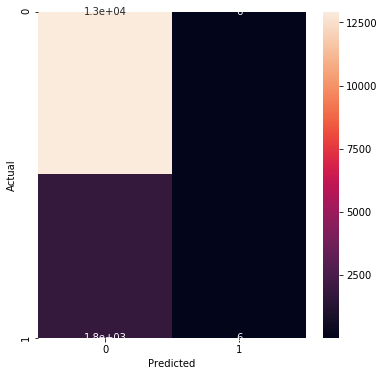

In [3371]:
fig = plt.figure(figsize=(6, 6))
cm1 = confusion_matrix(y_test, y_pred_1)
sns.heatmap(cm1, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm1

Видим, что наша модель имеет очень слабую предсказательную способность и не способна выявлять дефолтных клиентов

# Займёмся подбором гиперпараметров

In [3372]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

iter_=50
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10, 20, 40 )

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])


C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trigu\Anaconda3\lib\site-packa

C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this trai

Лучшее Penalty: l2
Лучшее C: 1.0


C:\Users\trigu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Не смотря на длинное сообщение об ошибке, мы выяснили, что лучшее Penalty: l2,
лучшее C: 1.0

Применим вышенайденные гиперпараметры к новой модели

In [3373]:
model_2 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2',  max_iter = 1000)

model_2.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [3374]:
y_pred_2=model_2.predict(X_test)

Определим снова метрики, кривую ROC AUC и матрицу ошибок

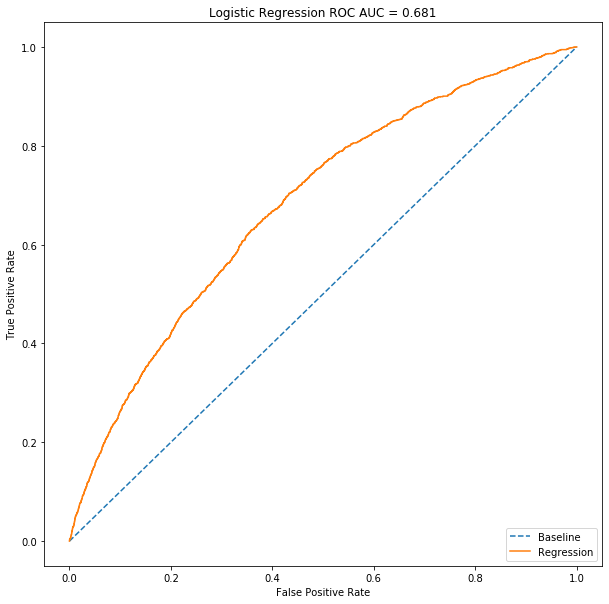

In [3375]:
probs_2 = model_2.predict_proba(X_test)
probs_2 = probs_2[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_2)
roc_auc = roc_auc_score(y_test, probs_2)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [3376]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_2)))
print('Precision:'+str(precision_score(y_test, y_pred_2)))
print('Recall:'+str(recall_score(y_test, y_pred_2)))
print('f1: ' + str(f1_score(y_test, y_pred_2)))

Accuracy:0.876219512195122
Precision:0.5
Recall:0.003284072249589491
f1: 0.006525285481239804


array([[12927,     6],
       [ 1821,     6]], dtype=int64)

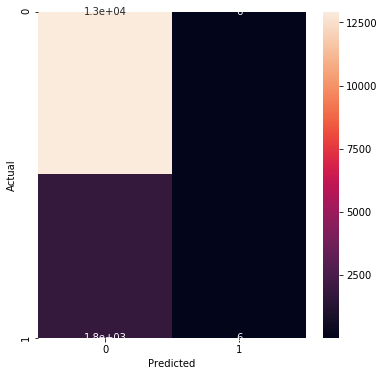

In [3377]:
fig = plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm2, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm2

Подстановка гиперпараметров не смогла улучшить ситуацию

Возможно, проблемой является несбалансированность выборки по целевой переменной.

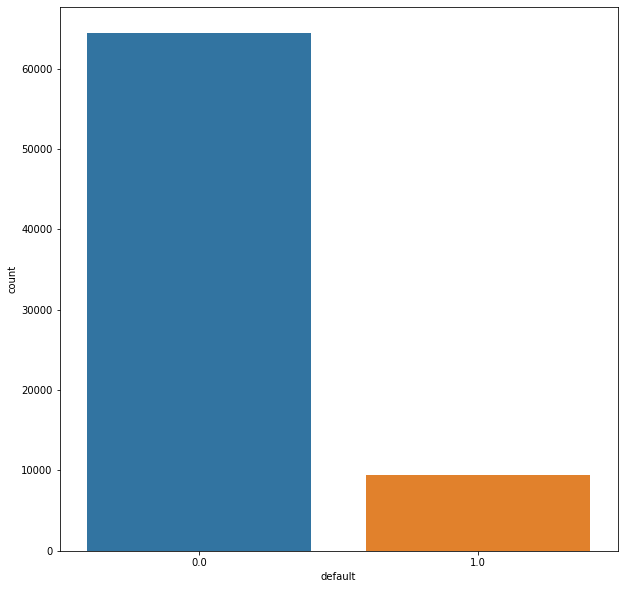

In [3378]:
sns.countplot(x=data['default'], data=data_train)

Попробуем для тренировочной выборки сократить количество недефолтных клиентов, реализуя таким образом undersampling. 

In [3379]:
data_reduced_def_0=data[:15000][(data['default']==0)&(data['Train']==1)]
data_reduced_def_0.head(3)


C:\Users\trigu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0.0,1,6.635054,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0.0,1,6.050582,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0.0,1,6.635054,3


In [3380]:
data_reduced_def_1=data[(data_train['default']==1)&(data['Train']==1)]
data_reduced_def_1.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta,education_label
18,26038,2014-02-02,1,0,3.610918,0,0,0.0,0,-1.971907,...,1,3,11.002117,4,1,0,1.0,1,6.623640,1
23,51615,2014-02-28,3,1,3.332205,1,1,0.0,0,-2.178540,...,2,3,10.915107,4,3,0,1.0,1,6.269172,3
24,35287,2014-02-11,3,0,3.295837,0,0,0.0,0,-1.436580,...,1,2,10.165890,1,2,0,1.0,1,6.514594,3


In [3381]:
data_reduced=data_reduced_def_0.append(data_reduced_def_1)
data_reduced.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0.0,1,6.635054,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0.0,1,6.050582,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0.0,1,6.635054,3


таким образом мы сократили выборку, но сделали ее более сбалансированной по целевой переменной.

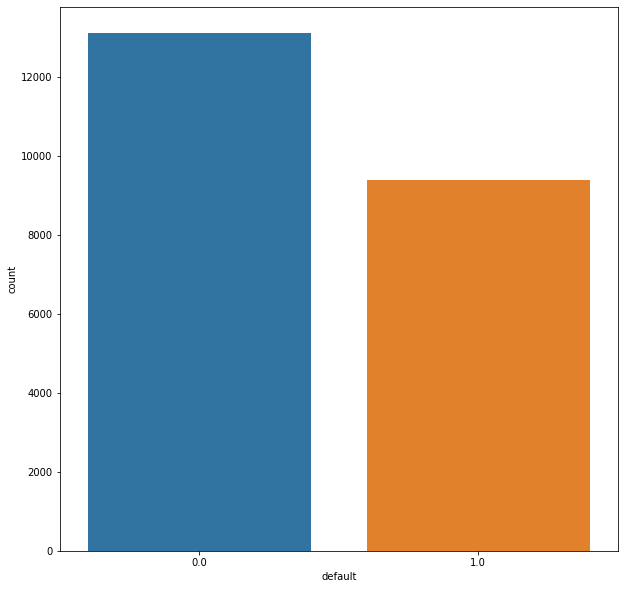

In [3382]:
sns.countplot(x=data_reduced['default'], data=data_reduced)  


In [3383]:

#data_reduced=data_reduced.drop(['age', 'sex', 'client_id', 'app_date'], axis=1)


Попробуем избавиться от выбросов для некоторых числовых признаков

Сначала определим выбросы

In [3384]:
range_outliers(data_reduced['income'])

медиана:10.308985993422082, 25% персентиль:9.90353755128617, 75% персентиль:10.714439990727769, IQR:0.8109024394415982, границы выбросов: [8.687183892123773,11.930793649890166]


In [3385]:
range_outliers(data_reduced['bki_request_cnt'])

медиана:1.0986122886681098, 25% персентиль:0.6931471805599453, 75% персентиль:1.3862943611198906, IQR:0.6931471805599453, границы выбросов: [-0.3465735902799726,2.4260151319598084]


Отфильтруем значения 'income' и 'bki_request_cnt' превышающие границы выбросов

In [3386]:
data_reduced=data_reduced[(data_reduced['income']<62484.64)& (data_reduced['bki_request_cnt']<3.96)]
data_reduced.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta,education_label
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0.0,1,6.635054,3
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0.0,1,6.050582,3
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0.0,1,6.635054,3


Применем всё те же преобразования данных

In [3387]:
for column in bin_cols:
    
    data_reduced[column] = label_encoder.fit_transform(data_reduced[column][data['Train']==1])

In [3388]:
for column in num_cols:
    data_reduced[column] = np.log(data_reduced[column] + 1)
data_reduced.head(3)   

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,timedelta,education_label
0,25905,2014-02-01,3,1,1.637663,1,1,0.000000,0,-2.008753,...,1,2,2.379378,4,1,0,0.0,1,2.03275,3
1,63161,2014-03-12,3,0,1.628131,0,0,0.000000,0,-1.532276,...,2,3,2.384372,4,1,0,0.0,1,1.95311,3
2,25887,2014-02-01,3,1,1.448822,1,0,0.741276,0,-1.408142,...,1,2,2.425598,1,4,1,0.0,1,2.03275,3


In [3389]:
X_cat_reduced = OneHotEncoder(sparse = False).fit_transform(data_reduced[cat_cols].values)

In [3390]:
X_num_reduced =StandardScaler().fit_transform(data_reduced[num_cols].values)

Объеденим новый тренировочный массив и вектор целевой переменной

In [3391]:
X_reduced=np.hstack([X_num_reduced, data_reduced[bin_cols].values, X_cat_reduced])
y_reduced=data_reduced['default'].values

Разделим массивы на тренировочный и тестовый сет

In [3392]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_SEED)

создадим и применим модель

In [3393]:
model_3 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2', class_weight =None,
                           dual = False, fit_intercept =True, intercept_scaling = 1,
                          l1_ratio = None, max_iter = 1000,  n_jobs = None, tol = 0.0001, verbose = 0,warm_start = False,)

model_3.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

предскажем значения 

In [3394]:
y_pred_reduced=model_3.predict(X_test)

Определим снова метрики, кривую ROC AUC и матрицу ошибок

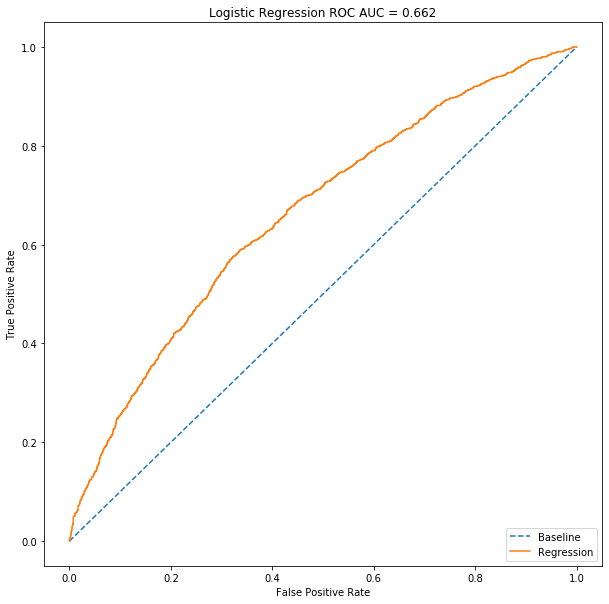

In [3395]:
probs_3 = model_3.predict_proba(X_test)
probs_3 = probs_3[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_3)
roc_auc = roc_auc_score(y_test, probs_3)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [3396]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_reduced)))
print('Precision:'+str(precision_score(y_test, y_pred_reduced)))
print('Recall:'+str(recall_score(y_test, y_pred_reduced)))
print('f1: ' + str(f1_score(y_test, y_pred_reduced)))

Accuracy:0.6402669632925473
Precision:0.5873015873015873
Recall:0.42045454545454547
f1: 0.4900662251655629


array([[2101,  546],
       [1071,  777]], dtype=int64)

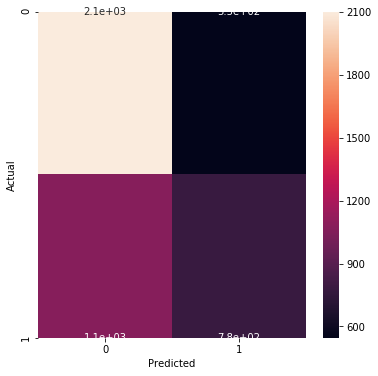

In [3407]:
fig = plt.figure(figsize=(6, 6))
cm3 = confusion_matrix(y_test, y_pred_reduced)
sns.heatmap(cm3, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm3

В результате уменьшения выборки с целью её сбалансирования метрики и матрица ошибок существенно улучшились. При чем чем сильнее я урезала выборку до более сбалансированной тем больше становился он становился. 
Площать под кривой всё равно ROC AUC уменшилась. 

Воспользуемся методом coef_ для определения значимости признаков

Feature: 0, Score: -0.07793
Feature: 1, Score: 0.29458
Feature: 2, Score: -0.10305
Feature: 3, Score: 0.23948
Feature: 4, Score: 0.13081
Feature: 5, Score: 0.22253
Feature: 6, Score: -0.01533
Feature: 7, Score: -0.25747
Feature: 8, Score: -0.52217
Feature: 9, Score: -0.20816
Feature: 10, Score: -0.57355
Feature: 11, Score: 0.03342
Feature: 12, Score: -0.21771
Feature: 13, Score: 0.45238
Feature: 14, Score: 0.29940
Feature: 15, Score: -0.23363
Feature: 16, Score: 0.32280
Feature: 17, Score: -0.09523
Feature: 18, Score: -0.20831
Feature: 19, Score: 0.08748
Feature: 20, Score: 0.11477


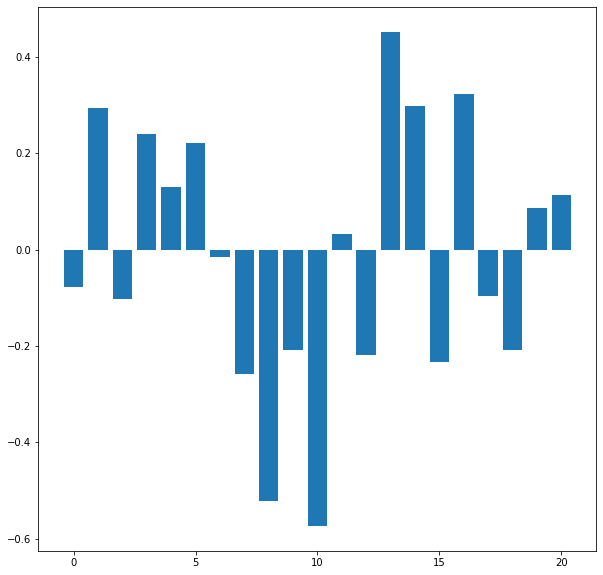

In [3398]:
importance = model_3.coef_[0]
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Исходя из этого мы можем попробовать убрать фичи с наименьшим влиянием

In [3399]:
X_reduced_4=np.delete(X_reduced, [6, 19],1)

In [3400]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_4, y_reduced, test_size=0.2, random_state=RANDOM_SEED)

In [3401]:
model_4 = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1.0, penalty= 'l2', class_weight =None,
                           dual = False, intercept_scaling = 1,
                          l1_ratio = None, max_iter = 1000,  n_jobs = None, tol = 0.0001, verbose = 0,warm_start = False,)

model_4.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [3402]:
y_pred_4=model_4.predict(X_test)


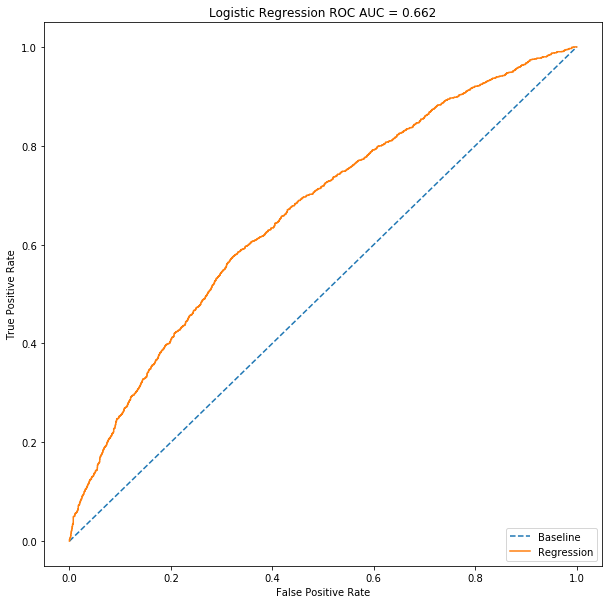

In [3403]:
probs_4 = model_4.predict_proba(X_test)
probs_4 = probs_4[:,1]


fpr, tpr, threshold = metrics.roc_curve(y_test, probs_4)
roc_auc = roc_auc_score(y_test, probs_4)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [3404]:
print('Accuracy:'+str(accuracy_score(y_test, y_pred_4)))
print('Precision:'+str(precision_score(y_test, y_pred_4)))
print('Recall:'+str(recall_score(y_test, y_pred_4)))
print('f1: ' + str(f1_score(y_test, y_pred_4)))

Accuracy:0.639377085650723
Precision:0.5859197577592733
Recall:0.41883116883116883
f1: 0.4884821710318712


array([[2100,  547],
       [1074,  774]], dtype=int64)

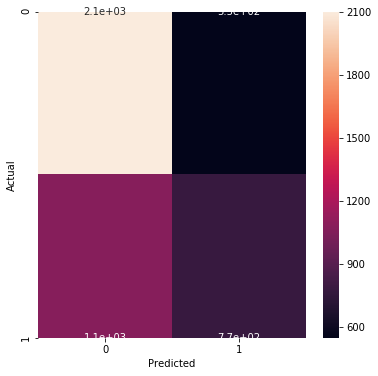

In [3406]:
fig = plt.figure(figsize=(6, 6))
cm4 = confusion_matrix(y_test, y_pred_4)
sns.heatmap(cm4, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm4

При удалении фич с наименьшим влиянием f1-score, Recall и Accuracy стал меньше. Поэтому приймем предидущую model_3 за оптимальную

In [ ]:
submission_pred_prob = model_4.predict_proba(X_Test)[:,1]
submission_predict = model_4.predict(X_Test)

submission = pd.DataFrame({'client_id': data_test['client_id'].values, 
                            'default': submission_pred_prob})
submission.to_csv('submission.csv', index=False)

